In [24]:
import numpy
from math import *
from scipy.fftpack import *
from matplotlib import pyplot, cm
from matplotlib import rcParams
%matplotlib inline
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 8

# Transformada Rápida de Fourier

## El Problema

Consideremos la ecuación de Poisson:

$$ \frac{\partial^2 \phi}{\partial x^2}+\frac{\partial^2 \phi}{\partial y^2} = \frac{1}{\pi^2}\left(30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)+30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-4 \pi^2 \left(\frac{x}{\pi}-1\right)\sin(2y)\right) $$

con condiciones de contorno:

$$ \phi(0, y)=\phi(\pi, y)=\phi(x, 0)=\phi(x, \pi) = 0 $$

que puede reescribirse como:

$$ \nabla^2 \phi = f(x,y) $$

donde $$f(x,y) = \frac{1}{\pi^2}\left(30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)+30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-4 \pi^2 \left(\frac{x}{\pi}-1\right)\sin(2y)\right) $$

In [25]:
N = 128
x = numpy.linspace(0., pi, N)
y = numpy.linspace(0., pi, N)
h = pi/(N-1)

In [26]:
def f(x, y):
    N = len(x)
    f = numpy.zeros((N, N))
    for i in range(N):
        for j in range(N):
            f[i, j] = (1./pi**2)*(30.*((x[i]/pi)\
                                **2-x[i]/pi)+30.*((y[j]/pi)**2.-y[j]/pi)-4*(pi**2.)\
                                  *(x[i]/pi-1.)*sin(2*y[j]))
    return f

## Solución Analítica

La solución analítica de este problema está dada por:
$$ \phi(x, y) = 15 \left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right) \left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-\sin(2y) \frac{\sinh(2 \pi (\frac{x}{\pi}-1))}{\sinh(2 \pi)}+\left(\frac{x}{\pi}-1\right)\sin(2y) $$

In [27]:
def phi_ana(x,y):
    N = len(x)
    f = numpy.zeros((N, N))
    for i in range(N):
        for j in range(N):
            f[i, j] = 15.*((x[i]/pi)**2-x[i]/pi)*((y[j]/pi)**2.\
                                -y[j]/pi)- (sin(2*y[j])*sinh(2*pi*(x[i]/pi-1.)))\
                                /sinh(2*pi)+(x[i]/pi-1.)*sin(2*y[j])
    return f

En la siguiente figura podemos ver un gráfico de la solución.

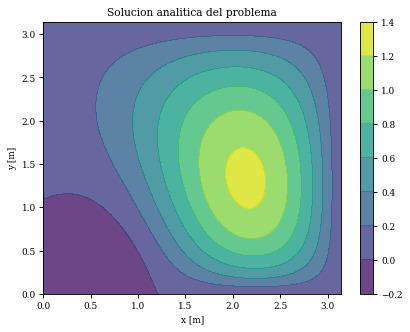

In [28]:
phi_analitica = phi_ana(x, y)

fig = pyplot.figure(figsize=(6,4.5), dpi = 80);
pyplot.contourf(x, y, phi_analitica, alpha = 0.8, cmap = cm.viridis)
pyplot.colorbar()
pyplot.title('Solucion analitica del problema')
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]');

## Solución por Método Espectral

Definamos algunas funciones de las transformadas del seno discreta

In [29]:
from numpy import empty,arange,exp,real,imag,pi
from numpy.fft import rfft,irfft

In [30]:
# 1D DST Type-I

def dst(y):
    N = len(y)
    y2 = empty(2*N,float)
    y2[0] = y2[N] = 0.0
    y2[1:N] = y[1:]
    y2[:N:-1] = -y[1:]
    a = -imag(rfft(y2))[:N]
    a[0] = 0.0

    return a

# 1D inverse DST Type-I

def idst(a):
    N = len(a)
    c = empty(N+1,complex)
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = irfft(c)[:N]
    y[0] = 0.0

    return y


In [31]:
# 2D DST

def dst2(y):
    M = y.shape[0]
    N = y.shape[1]
    a = empty([M,N],float)
    b = empty([M,N],float)

    for i in range(M):
        a[i,:] = dst(y[i,:])
    for j in range(N):
        b[:,j] = dst(a[:,j])

    return b

# 2D inverse DST

def idst2(b):
    M = b.shape[0]
    N = b.shape[1]
    a = empty([M,N],float)
    y = empty([M,N],float)

    for i in range(M):
        a[i,:] = idst(b[i,:])
    for j in range(N):
        y[:,j] = idst(a[:,j])

    return y

In [32]:
fvalues = f(x, y) # definimos los valores de f

In [33]:
fvalues_t = dst2(fvalues) # calculamos sus transformadas

In [34]:
phi_t = numpy.zeros((N, N)) # calculamos phi_t(f_t))

for k in range(1, N-1):
    for l in range(1, N-1):
        phi_t[k,l] = fvalues_t[k,l]/(-k**2-l**2)

In [35]:
phi = idst2(phi_t) # calculamos la inversa de phi_t

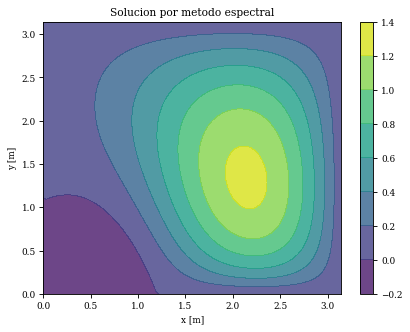

In [36]:
fig = pyplot.figure(figsize=(6,4.5), dpi = 80);
pyplot.contourf(x, y, phi, alpha = 0.8, cmap = cm.viridis)
pyplot.colorbar()
pyplot.title('Solucion por metodo espectral')
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]');

## Solución por diferencias finitas (2D DST)

In [37]:
fvalues = f(x, y) # definimos los valores de f

In [38]:
fvalues_t = dst2(fvalues) # calculamos sus transformadas

In [39]:
phi_t = numpy.zeros((N, N)) # calculamos phi_t(f_t))

for k in range(1, N-1):
    for l in range(1, N-1):
        phi_t[k,l] = fvalues_t[k,l]*(h**2/(4*cos((k+l)*h/2)*cos((k-l)*h/2)-4.))

In [40]:
phi = idst2(phi_t) # calculamos la inversa de phi_t

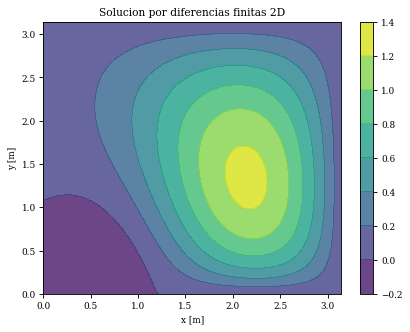

In [41]:
fig = pyplot.figure(figsize=(6,4.5), dpi = 80);
pyplot.contourf(x, y, phi, alpha = 0.8, cmap = cm.viridis)
pyplot.colorbar()
pyplot.title('Solucion por diferencias finitas 2D')
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]');

## Solución por diferencias finitas (1D DST)

In [42]:
fvalues = f(x, y) # definimos los valores de f

In [43]:
f_t1D = numpy.zeros((N, N))
for j in range(N):
    f_t1D[:, j] = dst(fvalues[:, j])

In [47]:
phi_t1D = numpy.zeros((N, N))
for k in range(N):
    A = numpy.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if abs(i - j) == 1:
                A[i, j] = -1
            if i == j:
                A[i, j] = 4. - 2.*cos(k*h)
    b = numpy.zeros(N)
    for j in range(N):
        b[j] = -h**2 * f_t1D[k, j]
    phi_t1D[k, :] = numpy.linalg.solve(A, b)

In [48]:
phi = numpy.zeros((N, N))
for j in range(N):
    phi[:, j] = idst(phi_t1D[:, j])

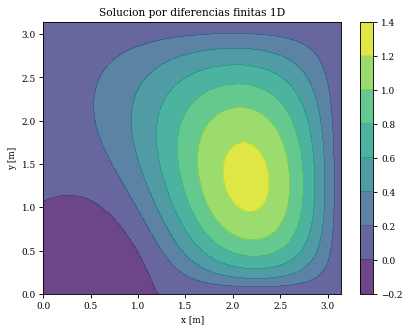

In [49]:
fig = pyplot.figure(figsize=(6,4.5), dpi = 80);
pyplot.contourf(x, y, phi, alpha = 0.8, cmap = cm.viridis)
pyplot.colorbar()
pyplot.title('Solucion por diferencias finitas 1D')
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]');